In [104]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

<Strong> Reading in the data as a DataFrame grabbing the headers , then , converting to a numpy array.</Strong>

In [105]:
df = pd.read_csv("../cryptoData/ethDataHistoryHour.csv")

In [106]:
df_headers = list(df.columns)

In [107]:
ethArray = df.to_numpy()

<Strong> Creating a plot with open price </Strong>

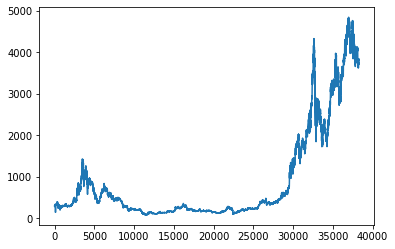

In [108]:
closingPrice = ethArray[:,1]
plt.plot( range ( len (closingPrice) ) , closingPrice )

<Strong> The way the book does it. </Strong>

In [109]:
data_dir = '/users/jackyboy/Desktop/FYP/cryptoData'

fname = os.path.join(data_dir, 'ethDataHistoryHour.csv')

f = open(fname)
data = f.read()
f.close()

#Adding an empty column at the bottom of list. :(
lines = data.split('\n')

#The headings
header = lines[0].split(',')

#Data without the headings
lines = lines[1:-1]

In [110]:
#Getting rid of the date header 
float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

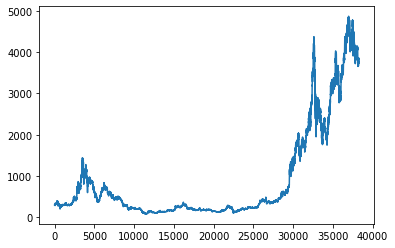

In [111]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

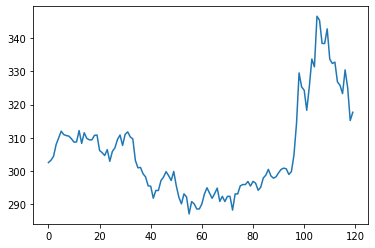

In [112]:
plt.plot(range(120) , temp[:120])

<Strong> We need to normalize the data so all take same values on a similar scale. Only Training. </Strong>

In [113]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [114]:
print(float_data[0])

[-0.51054529 -0.51165099 -0.51068203 -0.51016505 -0.79504295]


<Strong> Generator to grab batches of data from past aswell as the target values from future. </Strong>

In [115]:
#Data = data which we normalized
#Loopback = how many timesteps back the data should go 
#How mnay timesteps in the future the target should be
#min_index and max_index = to delimit the data you chose from (good for chosing validaiton)
#Shuffle or draw them in chronocological order
#Number of samples per batch
#Period in timesteps youll pick from your data


def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [116]:
#10 days ago
lookback = 1440

#one timestep a day
step = 6

# time in future
delay = 144

batch_size = 128

In [117]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)


val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [118]:
val_steps = (300000 - 200001 - lookback)

In [119]:
test_steps = (len(float_data) - 300001 - lookback)

In [120]:

from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop


model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(), loss='mae')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 32)          832       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,353
Trainable params: 12,353
Non-trainable params: 0
__________________________________________________

In [121]:
history = model.fit_generator(train_gen,
                                  steps_per_epoch=500,
                                  epochs=20,
                                  validation_data=val_gen,
                                  validation_steps=val_steps)

/var/folders/_f/jpr9q2w52wzg1v439ryj1bk00000gn/T/ipykernel_69650/1578168746.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


IndexError: index 52778 is out of bounds for axis 0 with size 38283